# Optimization benchmark for non-convex sample functions

Functions evaluated:

- [Branin](https://www.sfu.ca/~ssurjano/branin.html)
- [Rosenbrock](https://en.wikipedia.org/wiki/Rosenbrock_function)
- [Rastrigin](https://en.wikipedia.org/wiki/Rastrigin_function)

In [97]:
import time
import json
import math
import itertools
import numpy as np
import pandas as pd
from math import pi, cos, sqrt
from timeit import default_timer as timer

evaluation_delay = 0

# Optima in [-5, 10] x [0, 15]
branin_minima = [(-pi, 12.275), (pi, 2.275), (9.42478, 2.475)]
def branin(x):
    a=1
    b=5.1/(4*pi**2)
    c=5/pi
    r=6
    s=10
    t=1/(8*pi)
    return a*(x[1]-b*x[0]**2+c*x[0]-r)**2 + s*(1-t)*cos(x[0])+s  

ROSENBROCK_N = 100
rosenbrock_minima = [(1,) * ROSENBROCK_N]
def rosenbrock(x):
    return sum(100.0*(np.array(x[1:])-np.array(x[:-1])**2.0)**2.0 + (1-np.array(x[:-1]))**2.0)

RASTRIGIN_N = 100
# Optima in [-5.12, 5.12] x [-5.12, 5.12]
rastrigin_minima = [(0,) * RASTRIGIN_N]
def rastrigin(x):
    A = 10
    n = len(x)
    return A * n + sum([x_i**2 - A*math.cos(2*math.pi*x_i) for x_i in x])

def opt_error(x, minima):
    def l2_norm(x,y):
        return np.linalg.norm(np.array(x) - np.array(y))
    distances = [l2_norm(x,m) for m in minima]
    return min(distances)

functions = [
    #{
    #    'function': branin,
    #    'initial_guesses': [np.zeros(2), 
    #                        np.ones(2),
    #                        np.random.rand(2)],
    #    'minima': branin_minima,
    #    'bounds': [(-5,10), (0,15)],
    #}, 
    #{
    #    'function': rosenbrock,
    #    'initial_guesses': [np.zeros(ROSENBROCK_N), 
    #                        np.random.rand(ROSENBROCK_N)*10-5],
    #    'minima': rosenbrock_minima,
    #    'bounds': [(-10,10)] * ROSENBROCK_N,
    #}, 
    {
        'function': rastrigin,
        'initial_guesses': [np.ones(RASTRIGIN_N), 
                            np.random.rand(ROSENBROCK_N)*10-5],
        'minima': rastrigin_minima,
        'bounds': [(-5.12,5.12)] * RASTRIGIN_N,
    },
]

## Classical optimization

Optimization methods used (with different initial guesses tested):

- Nelder-Mead
- BFGS
- L-BFGS-B

In [46]:
from scipy.optimize import minimize
from IPython.display import display, HTML

methods = ['Nelder-Mead', 'BFGS', 'L-BFGS-B']


params_set = itertools.product(functions,            # Objective functions
                               methods)              # Optimization methods

results_df = pd.DataFrame()
for f, method in params_set:
    for initial_guess in f['initial_guesses']:
        function = f['function']
        start = timer()
        result = minimize(function, initial_guess, method=method)
        elapsed_time = timer() - start
        x = result['x']
        fun = result['fun']
        error = opt_error(x, f['minima'])
        success = result['success']
        nfev = result['nfev']
        nit = result['nit']
        results_df = results_df.append(
            {
                'function': function.__name__,
                'method': method,
                'initial_guess': initial_guess,
                'time': elapsed_time,
                'solution': x,
                'error': error,
                'n_samples': None,
                'iterations': nit,
                'evaluations': nfev,
                'prior_width': None,
                'success': success,
            }, ignore_index=True
        )

results_df

,function,method,initial_guess,time,solution,error,n_samples,iterations,evaluations,prior_width,success
0,rastrigin,Nelder-Mead,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.131181,"[0.9949464552455136, 0.9949569747938571, 0.994...",9.949577,None,5873.0,8046.0,None,1.0
1,rastrigin,Nelder-Mead,"[0.6723197968156649, 0.4770358774501551, 3.673...",3.083921,"[1.1085915857465944, -0.08877270032714725, 3.9...",29.983604,None,18456.0,20000.0,None,0.0
2,rastrigin,BFGS,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.165804,"[0.9949586342842665, 0.9949586342842665, 0.994...",9.949586,None,4.0,707.0,None,1.0
3,rastrigin,BFGS,"[0.6723197968156649, 0.4770358774501551, 3.673...",6.110460,"[0.9949586439422562, 1.1493741940967694e-08, 3...",30.309097,None,160.0,25351.0,None,1.0
4,rastrigin,L-BFGS-B,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.074255,"[0.9949586236224075, 0.9949586236224075, 0.994...",9.949586,None,3.0,505.0,None,1.0
5,rastrigin,L-BFGS-B,"[0.6723197968156649, 0.4770358774501551, 3.673...",0.127885,"[0.9949586384474599, -3.523948364439822e-07, 3...",30.309097,None,12.0,1414.0,None,1.0


In [3]:
results_df[results_df.method.eq('Nelder-Mead')]

,function,method,initial_guess,time,solution,error,n_samples,iterations,evaluations,prior_width,success
0,branin,Nelder-Mead,"[0.0, 0.0]",0.004819,"[3.1416056975014306, 2.274984503003412]",0.000020,None,80.0,152.0,None,1.0
1,branin,Nelder-Mead,"[1.0, 1.0]",0.003238,"[3.1415829149104244, 2.2750048974181087]",0.000011,None,51.0,97.0,None,1.0
2,branin,Nelder-Mead,"[0.9379770338511719, 0.5202634109718499]",0.003581,"[3.1416045900595524, 2.2750403950214566]",0.000042,None,55.0,106.0,None,1.0
9,rosenbrock,Nelder-Mead,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.110806,"[0.9581994239135405, 0.9204737947316217, 0.833...",2.201578,None,1458.0,2000.0,None,0.0
10,rosenbrock,Nelder-Mead,"[-4.004450453075565, -1.296549838305178, -3.27...",0.101601,"[-0.24485912731459725, -0.47388166997496617, 0...",3.667383,None,1445.0,2000.0,None,0.0
15,rastrigin,Nelder-Mead,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.011604,"[0.9949388581678369, 0.9949292307401689, 0.994...",3.146313,None,161.0,268.0,None,1.0
16,rastrigin,Nelder-Mead,"[-4.296947494361626, -2.389199369027364, -1.91...",0.058559,"[-3.979766733125628, -1.9898996135499079, -1.9...",10.482384,None,891.0,1264.0,None,1.0


## Bayesian optimization

- Model used: Gaussian process
- Number of samples: 1, 10, 20
- Optimization iterations: 10, 20, 50, 100
- (Flat) prior for the optimum: No prior, very specific prior, less specific prior

In [ ]:
import math
import sys
import os
from contextlib import redirect_stdout
from hypermapper import optimizer
from concurrent.futures import ProcessPoolExecutor

N_CORES = 1
N_PRIOR_BINS = 10

def function_wrapper(func):    
    def wrapper(X):
        X2 = [X['x{}'.format(i+1)] for i in range(len(X))]
        return func(np.array(X2))
    return wrapper

params_set = itertools.product(functions,            # Objective functions
                               ['gaussian_process'], # Model
                               [20],          # Number of samples
                               [1000],    # Optimization iterations
                               [-1])         # Use prior?

def bo_optimization(f, model, n_samples, optim_iters, prior_width, experiment_num):           
    example_scenario = {
        "application_name": "bo_tests_{}".format(experiment_num),
        "design_of_experiment": {
            "doe_type": "random sampling",
            "number_of_samples": n_samples
        },
        "optimization_objectives": ["Value"],
        "optimization_iterations": optim_iters,
        "models": {
            "model": model
        },
        "input_parameters" : {
        },
        #"print_posterior_best": True,
        #"print_best": True,
    }
    
    for i, bounds in enumerate(f['bounds']):            
        example_scenario['input_parameters']['x{}'.format(i+1)] = {
            'parameter_type': 'real',
            'values': bounds,
        }
        if prior_width != -1:
            a, b = f['bounds'][i]
            bounds_range = b - a
            m = f['minima'][0][i] # ith component of first minimum
            prior_bin = math.floor((m-a)/(b-a)*N_PRIOR_BINS)
            prior = np.array([1 if abs(i-prior_bin) < prior_width else 0 for i in range(N_PRIOR_BINS)])
            prior = prior / sum(prior)
            example_scenario['input_parameters']['x{}'.format(i+1)]['prior'] = prior.tolist()

    scenario_file_path = "bo_optimization_scenario_{}.json".format(experiment_num)
    with open(scenario_file_path, "w") as scenario_file:
        json.dump(example_scenario, scenario_file, indent=4)

    stdout = sys.stdout # Jupyter uses a special stdout and HyperMapper logging overwrites it. Save stdout to restore later
    start = timer()
    with open(os.devnull, 'w') as devnull:
        #with redirect_stdout(devnull):
            optimizer.optimize(scenario_file_path, function_wrapper(f['function']))
    elapsed_time = timer() - start
    sys.stdout = stdout

    df = pd.read_csv('bo_tests_{}_output_samples.csv'.format(experiment_num))
    best_found = df.sort_values('Value').iloc[1,:]

    x = list(best_found[0:len(f['bounds'])])
    error = opt_error(x, f['minima'])

    return {
            'function': f['function'].__name__,
            'method': 'BO',
            'initial_guess': None,
            'time': elapsed_time,
            'solution': x,
            'error': error,
            'n_samples': n_samples,
            'iterations': None,
            'evaluations': optim_iters,
            'prior_width': prior_width,
            'success': 1,
    }
        
bo_results_df = pd.DataFrame()
with ProcessPoolExecutor(N_CORES) as executor:
    futures = []
    for i, (f, model, n_samples, optim_iters, prior_width) in enumerate(params_set):
        futures.append(executor.submit(bo_optimization, f, model, n_samples, optim_iters, prior_width, i))
        
    results = [f.result() for f in futures]
    bo_results_df = pd.DataFrame(results)
    #bo_optimization(f, model, n_samples, optim_iters, prior_width)        
        
bo_results_df

Design of experiment phase, number of new doe samples = 20 .......
x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,Value,Timestamp
-2.6201801299803344,2.475785506135354,-1.6975140150396082,-3.398266643424819,3.443613710910051,-1.6015335814943534,-2.426065277614485,-0.0357032242167481,-4.481455913536887,-3.2405371016974898,-0.791986487971549,-5.094042073392221,-4.018491859945138,-4.863578079062924,2.6638892532118117,-0.2579723749763483,-1.1178144366701153,-2.105398277947541,0.12387935687042084,-2.677598332705403,-0.9436102533070247,-4.3088506229262755,-1.1604605113217383,-1.0761044730061142,2.4375749941682487,2.6234830331670684,5.1183798371561435,-2

In [64]:
futures[0].result()

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [7]:
df = results_df.append(bo_results_df)
df.to_csv('bo_optimization_comparison.csv')

## Comparison of BO parameters

<AxesSubplot:title={'center':'error'}, xlabel='evaluations'>

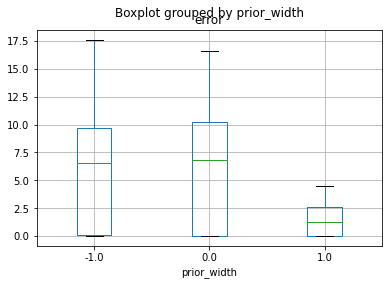

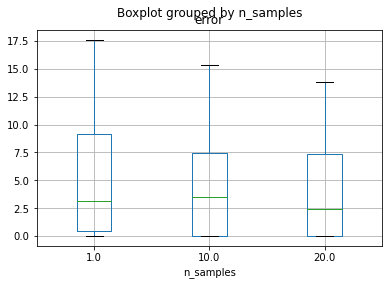

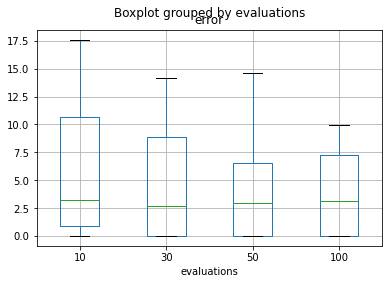

In [35]:
%matplotlib inline
df = pd.read_csv('bo_optimization_comparison.csv')
bo_df = df[df.method.eq('BO')]

bo_df.boxplot('error', by='prior_width')
bo_df.boxplot('error', by='n_samples')
bo_df.boxplot('error', by='evaluations')

## Comparison of branin function

<AxesSubplot:title={'center':'error'}, xlabel='evaluations'>

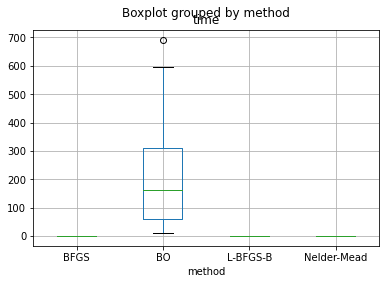

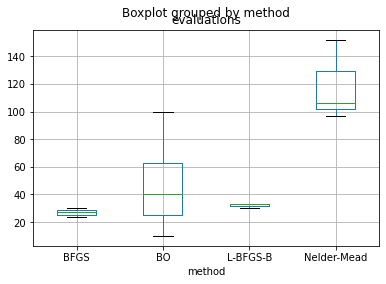

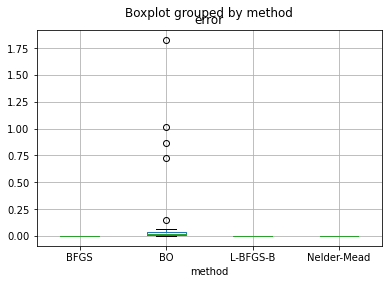

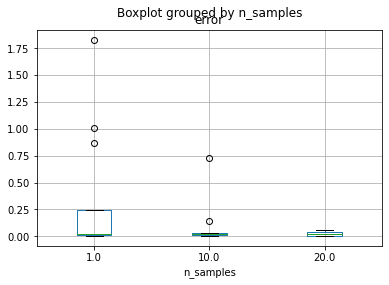

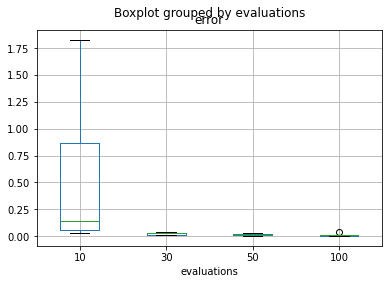

In [40]:
df_branin = df[df.function.eq('branin')]
df_branin.boxplot('time', by='method')
df_branin.boxplot('evaluations', by='method')
df_branin.boxplot('error', by='method')
df_branin.boxplot('error', by='n_samples')
df_branin[df_branin.method.eq('BO')].boxplot('error', by='evaluations')

## Comparison of rosenbrock function

<AxesSubplot:title={'center':'error'}, xlabel='evaluations'>

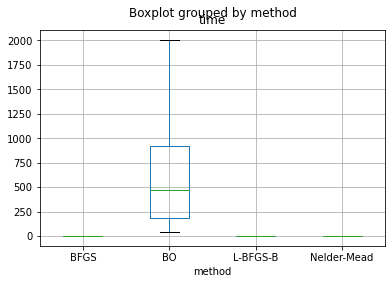

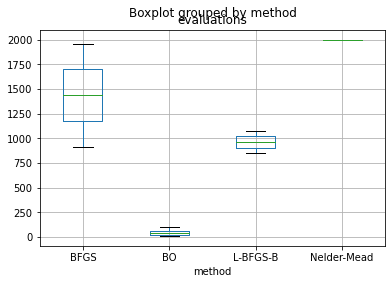

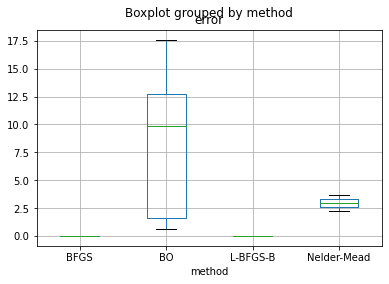

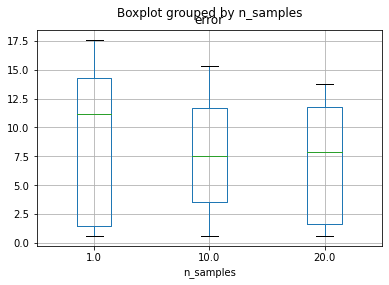

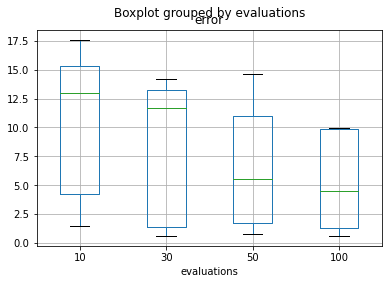

In [41]:
df_rosenbrock = df[df.function.eq('rosenbrock')]
df_rosenbrock.boxplot('time', by='method')
df_rosenbrock.boxplot('evaluations', by='method')
df_rosenbrock.boxplot('error', by='method')
df_rosenbrock.boxplot('error', by='n_samples')
df_rosenbrock[df_rosenbrock.method.eq('BO')].boxplot('error', by='evaluations')

## Comparison of rastrigin function

<AxesSubplot:title={'center':'error'}, xlabel='evaluations'>

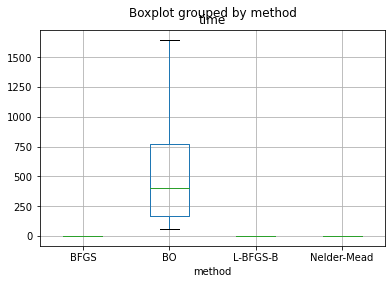

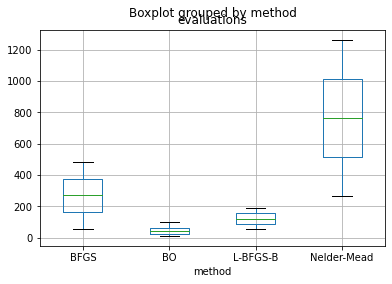

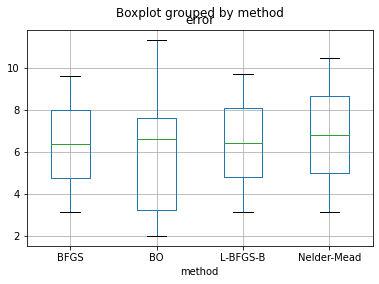

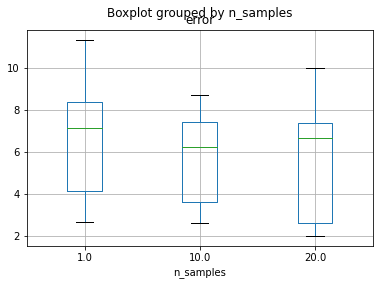

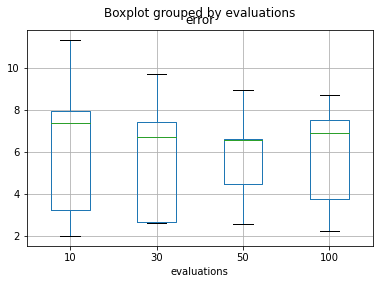

In [42]:
df_rastrigin = df[df.function.eq('rastrigin')]
df_rastrigin.boxplot('time', by='method')
df_rastrigin.boxplot('evaluations', by='method')
df_rastrigin.boxplot('error', by='method')
df_rastrigin.boxplot('error', by='n_samples')
df_rastrigin[df_rastrigin.method.eq('BO')].boxplot('error', by='evaluations')